In [1]:
%matplotlib widget
import numpy as np
from astropy import units as u, constants as c
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
import matplotlib
from astropy.convolution import convolve, Gaussian2DKernel
from astropy.io import fits
import scipy.interpolate as interp

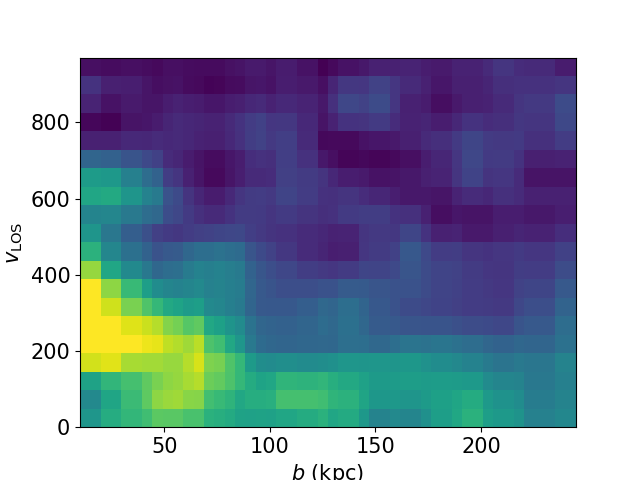

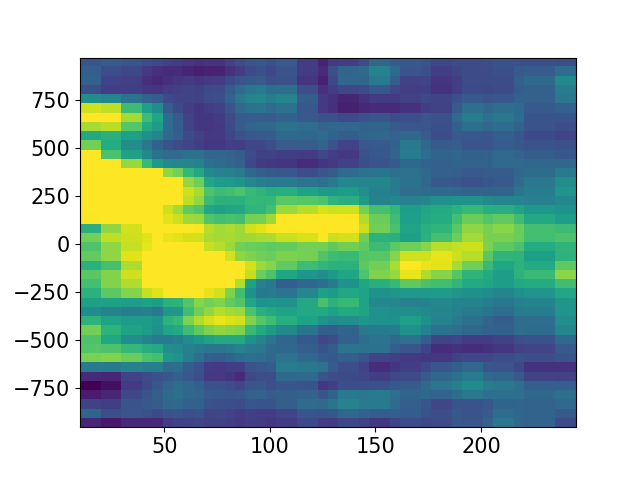

(40, 48)


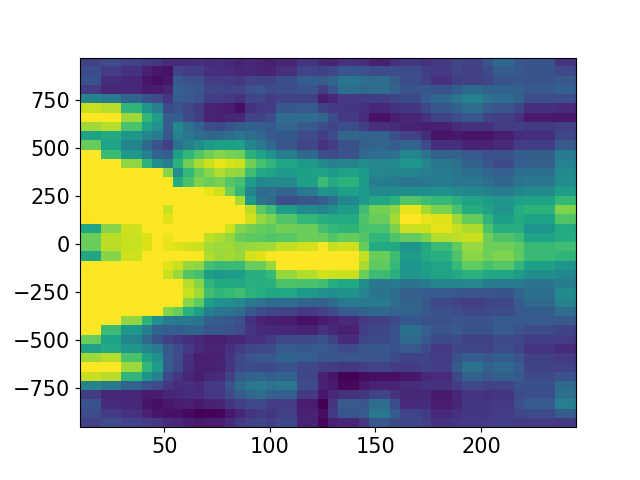

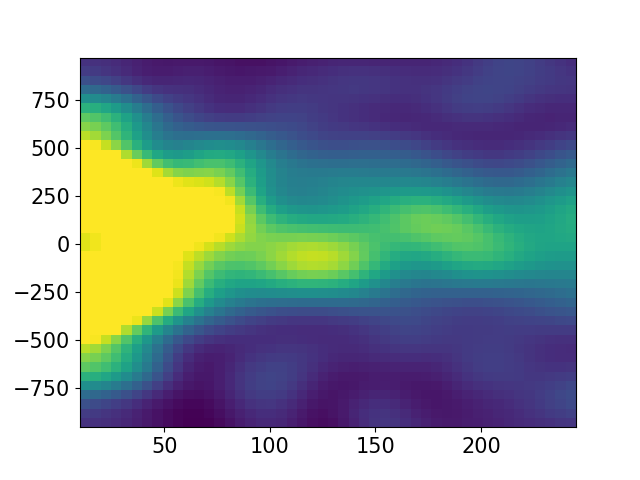

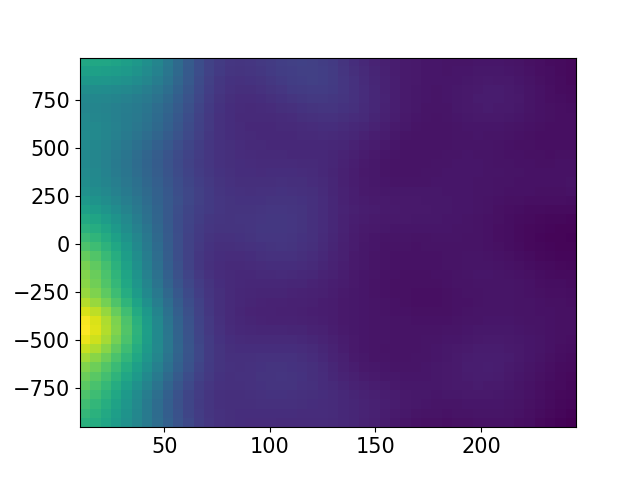

In [64]:
bvec = np.arange(10, 250, 5)
line, lwave = 'Lya', 1215.67
stack_wave = np.arange(1150, 1750, 0.2)

vscale = 3e5 * (stack_wave - lwave) / lwave
vcut = (vscale > -1000) & (vscale < 1000)

vs = vscale[vcut]

lya_map = fits.open('lya_map_250303.fits')[0].data


fig, ax = plt.subplots()

foldpt = int(lya_map.shape[0]/2)

bottomhalf = np.flip(lya_map[0:foldpt,:], axis=0)
tophalf = lya_map[foldpt:,:]

comb = np.nansum([bottomhalf,tophalf], axis=0)


ax.imshow(comb, origin='lower', aspect='auto', extent = [bvec.min(), bvec.max(), 0, vs.max()], vmax=1.4)
ax.set_ylabel('$v_\\mathrm{LOS}$')
ax.set_xlabel('$b$ (kpc)')
plt.show()

bluelya = np.flip(lya_map.copy(), axis=0) #[np.outer((vs > 0), (bvec <= 50))], axis=0)

plt.figure()
plt.imshow(bluelya, aspect='auto', origin='lower', extent = [bvec.min(), bvec.max(), vs.min(), vs.max()], vmax=0.5)
plt.show()

# print(lya_map.shape)
# bluelya = lya_map[np.outer((vs <= 0), (bvec <= 50))]
print(bluelya.shape)
lya_map[np.outer((vs > 0), (bvec <= 50))] = bluelya[np.outer((vs > 0), (bvec <= 50))]

# print(lya_map[np.outer((vs <= 0), (bvec <= 50))].shape)
# print(lya_map[np.outer((vs > 0), (bvec <= 50))].shape)
# err_map = fits.open('lya_error_map_250303.fits')[0].data

# lya_map[lya_map < 0.05] = 0


lya_conv = convolve(lya_map, Gaussian2DKernel(2,2), boundary = 'extend') # (b,v) = 1 kpc, 50 km/s -> 5 kpc, 100 km/s
err_conv = convolve(err_map, Gaussian2DKernel(2,2), boundary = 'extend') # (b,v) = 1 kpc, 50 km/s -> 5 kpc, 100 km/s

# lya_conv[lya_conv < 0.1] = 0

plt.figure()
plt.imshow(lya_map, aspect='auto', origin='lower', extent = [bvec.min(), bvec.max(), vs.min(), vs.max()], vmax=0.5)
plt.show()

plt.figure()
plt.imshow(lya_conv, aspect='auto', origin='lower', extent = [bvec.min(), bvec.max(), vs.min(), vs.max()], vmax=0.5)
plt.show()
plt.figure()
plt.imshow(err_conv, aspect='auto', origin='lower', extent = [bvec.min(), bvec.max(), vs.min(), vs.max()])
plt.show()

(41, 49)


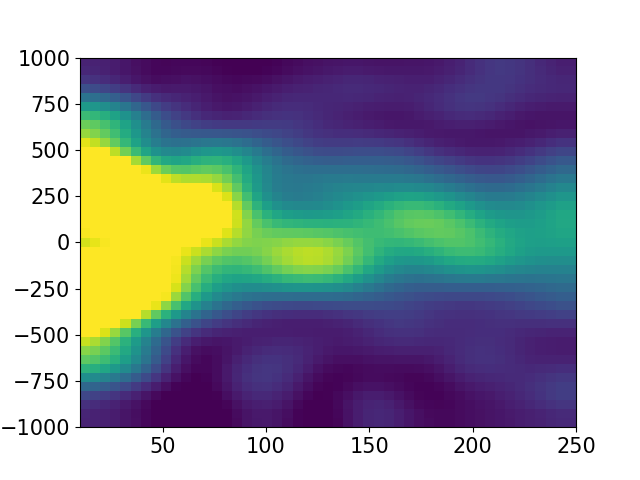

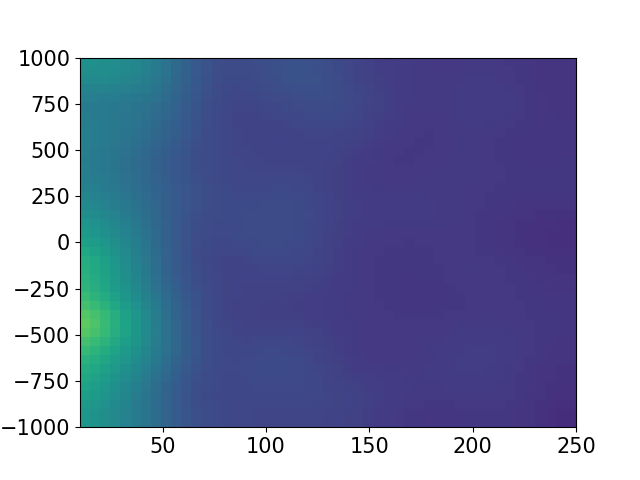

In [62]:
lya = interp.RectBivariateSpline(vs, bvec, lya_conv, kx=3, ky=3)
newb = np.arange(10,252.5,5)
newv = np.arange(-1000, 1025, 50)
new_lya = lya(newv, newb)

lyaerr = interp.RectBivariateSpline(vs, bvec, err_conv, kx=3, ky=3)
new_err = lyaerr(newv, newb)

print(new_lya.shape)

plt.figure()
plt.imshow(new_lya, aspect='auto', origin='lower', extent = [newb.min(), newb.max(), newv.min(), newv.max()], vmin=0, vmax = 0.5)
plt.show()

plt.figure()
plt.imshow(new_err, aspect='auto', origin='lower', extent = [newb.min(), newb.max(), newv.min(), newv.max()], vmin=0, vmax = 0.5)
plt.show()


fits.PrimaryHDU(new_lya).writeto('lya_conv_250311.fits', overwrite=True)
fits.PrimaryHDU(new_err).writeto('lya_error_conv_250311.fits', overwrite=True)
